In [27]:
import torch
import torch.utils.data.dataloader
import numpy as np
import tqdm
import matplotlib.pyplot as plt

import pcs.models.pointconv_simple
import pcs.dataset

In [28]:
BATCH_SIZE = 2 
NUM_CLASSES = 8

In [29]:
# TODO: more transforms, normalization, etc.
# TODO: aggregate more neighborhoods
# TODO: data augmentation
# TODO: stratification
dataset = pcs.dataset.SemSegDataset(
    data_dir="./data/aggregated/bild/",
    point_transforms=(lambda x: torch.tensor(x.T, dtype=torch.float32), ),
    label_transforms=(
        lambda x: torch.tensor(x-1, dtype=torch.long),
    )
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [30]:
EPOCH_LENGTH = len(dataset) // BATCH_SIZE + bool(len(dataset) % BATCH_SIZE)

In [31]:
model = pcs.models.pointconv_simple.PointConvNet(features=4, classes=NUM_CLASSES)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
model.train()

PointConvNet(
  (sa1): FeatureEncoder(
    (mlp_convs): ModuleList(
      (0): Conv2d(7, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (mlp_bns): ModuleList(
      (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (weightnet): WeightNet(
      (mlp_convs): ModuleList(
        (0): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (mlp_bns): ModuleList(
        (0-1): 2 x BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (linear): Linear(in_features=1024, out_features=64, bias=True)
    (bn_linear): BatchNorm1d(64, eps=1

In [33]:
def train_one_epoch() -> float:
    loss_agg = []
    pbar = tqdm.tqdm(dataloader, total=EPOCH_LENGTH)
    for data, labels in pbar:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        loss_agg.append(loss.item())
        pbar.set_description(f"Loss: {loss.item()}")
    mean_loss = np.array(loss_agg).mean()
    print(f"Mean loss: {mean_loss}")
    return mean_loss

losses = []
# Note: PoC, only 10 epochs
# Training takes long time nonetheless
for epoch in range(10):
    print(f"Epoch {epoch}")
    epoch_loss = train_one_epoch()
    losses.append(epoch_loss)

Epoch 0


Loss: 0.9627180099487305: 100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


Mean loss: 1.4680266362428664
Epoch 1


Loss: 0.767512857913971: 100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


Mean loss: 1.194491957128048
Epoch 2


Loss: 0.7247923016548157: 100%|██████████| 100/100 [02:23<00:00,  1.44s/it]


Mean loss: 1.0695748293399812
Epoch 3


Loss: 1.4309873580932617: 100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


Mean loss: 1.0023210227489472
Epoch 4


Loss: 0.5869309306144714: 100%|██████████| 100/100 [02:22<00:00,  1.43s/it]


Mean loss: 0.9212375447154045
Epoch 5


Loss: 0.6881910562515259: 100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


Mean loss: 0.8357695633172989
Epoch 6


Loss: 1.4634661674499512: 100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


Mean loss: 0.7564381082355977
Epoch 7


Loss: 0.11193381249904633: 100%|██████████| 100/100 [02:27<00:00,  1.47s/it]


Mean loss: 0.7460381774604321
Epoch 8


Loss: 0.3754695653915405: 100%|██████████| 100/100 [02:26<00:00,  1.46s/it]


Mean loss: 0.669399773478508
Epoch 9


Loss: 0.2020174264907837: 100%|██████████| 100/100 [02:25<00:00,  1.45s/it] 

Mean loss: 0.5318446274101735


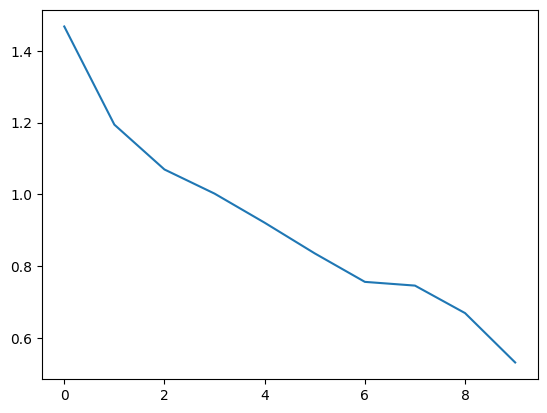

In [34]:
# TODO: verify correctness
plt.plot(losses)